In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [26]:
from luwiji.random_forest import illustration, demo

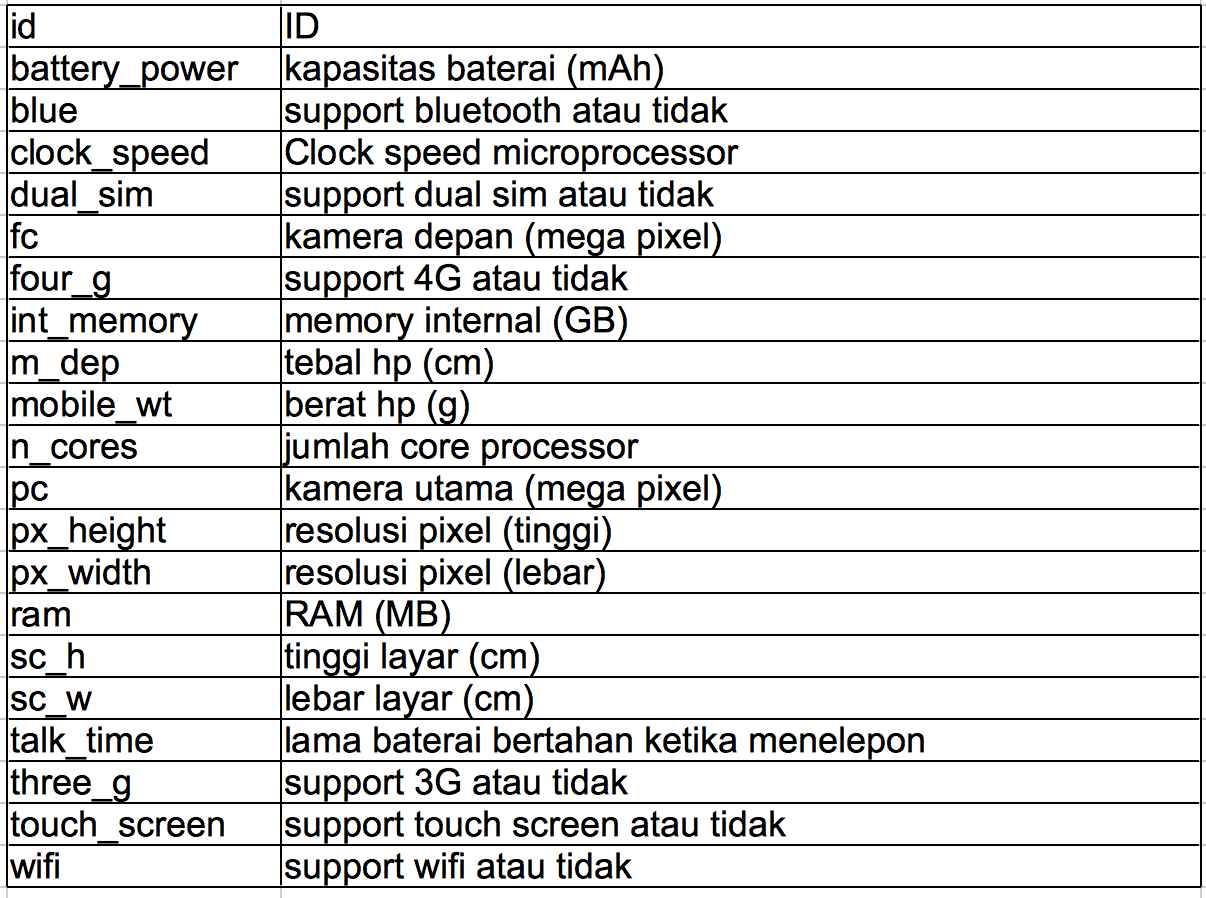

In [3]:
illustration.nomenklatur_mobile

# Import data

In [6]:
df = pd.read_csv('/home/yulius/Latihan-Data-Science/Data/mobile.csv')
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


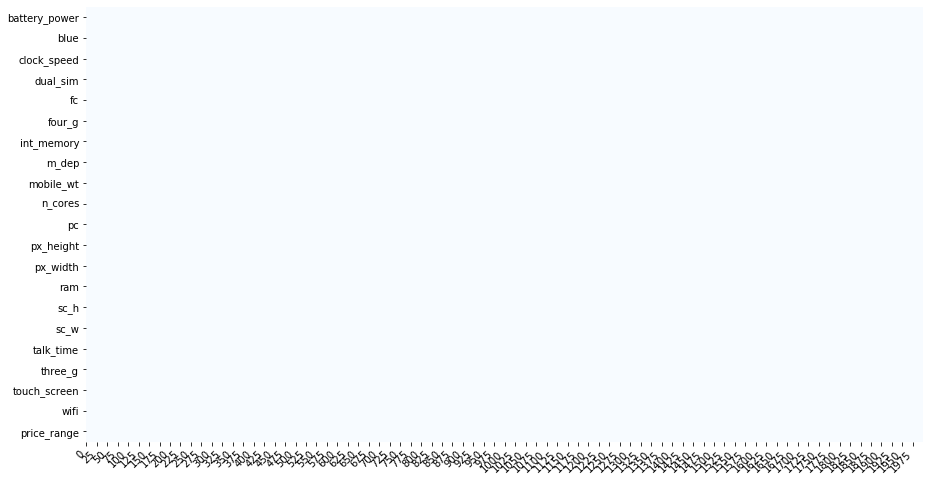

In [7]:
plot_missing_value(df)

# Dataset splitting

In [9]:
X = df.drop(columns="price_range")
y = df["price_range"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1600, 20), (400, 20), (1600,), (400,))

## Training

In [10]:
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp
from sklearn.ensemble import RandomForestClassifier

In [11]:
X_train[:1]

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
469,1845,1,0.5,1,10,0,61,0.3,96,1,12,292,695,1731,9,5,6,0,0,0


In [12]:
X_train.columns

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi'],
      dtype='object')

In [21]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["battery_power","clock_speed","fc","int_memory",
                            "m_dep","mobile_wt","n_cores","pc","px_height","px_width",
                             "ram", 'sc_h', 'sc_w', 'talk_time']),
    ('categoric', cat_pipe(encoder='onehot'), ["blue",'touch_screen','four_g', 'wifi','dual_sim','three_g']),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])


model = GridSearchCV(pipeline, gsp.rf_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:  1.3min finished


{'algo__max_depth': 20, 'algo__max_features': 0.8, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 200}
1.0 0.8806299817535773 0.9125


## Feature importance

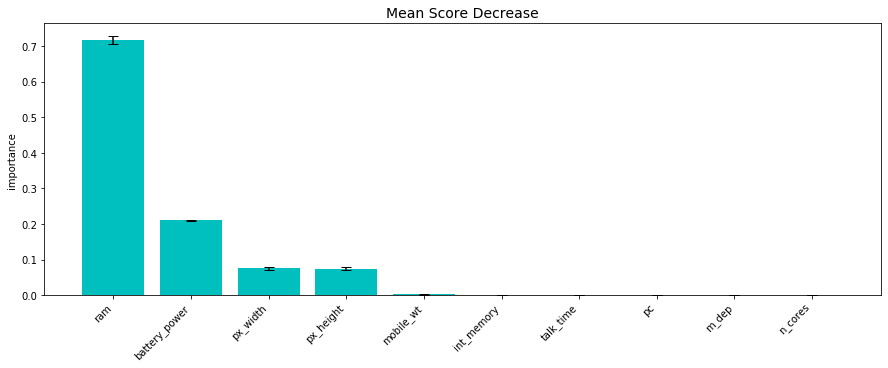

In [19]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

## Phase 2:

In [22]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ["battery_power",
                             "px_height","px_width","ram"])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])


model = GridSearchCV(pipeline, gsp.rf_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:   54.3s finished


{'algo__max_depth': 20, 'algo__max_features': 0.6, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 150}
1.0 0.9031264858888864 0.945


### Phase 3: try ploynomial feature

In [24]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), ["battery_power",
                             "px_height","px_width","ram"])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])


model = GridSearchCV(pipeline, gsp.rf_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:  1.5min finished


{'algo__max_depth': 20, 'algo__max_features': 0.3, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 200}
1.0 0.9262530654692891 0.95


# Random search cv

In [28]:
demo.grid_vs_random_search()

interactive(children=(Checkbox(value=False, description='show_score'), Output()), _dom_classes=('widget-intera…